In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.cluster import KMeans, DBSCAN
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import re
import ast
import joblib
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Download required NLTK data
try:
    nltk.data.find('tokenizers/punkt')
except LookupError:
    nltk.download('punkt')

try:
    nltk.data.find('corpora/stopwords')
except LookupError:
    nltk.download('stopwords')

try:
    nltk.data.find('corpora/wordnet')
except LookupError:
    nltk.download('wordnet')


[nltk_data] Error loading wordnet: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     unable to get local issuer certificate (_ssl.c:997)>


## 1. Load Cleaned Dataset

In [3]:
# Load the cleaned dataset
df = pd.read_csv('/Users/priyankamalavade/Desktop/Audible_Insights_Project/data/cleaned_audible_dataset.csv')


print(f"Dataset shape: {df.shape}")


Dataset shape: (6065, 14)


In [4]:
# Convert genres back to list format
df['Genres'] = df['Genres'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) and x.startswith('[') else [])

# Filter books with descriptions for NLP analysis
df_with_desc = df[df['Description_Clean'].notna() & (df['Description_Clean'].str.len() > 10)].copy()
print(f"Books with descriptions: {len(df_with_desc):,}")
print(f"Average description length: {df_with_desc['Description_Clean'].str.len().mean():.0f} characters")


Books with descriptions: 4,002
Average description length: 236 characters


## 2. Text Preprocessing

In [5]:
# Initialize text processing tools
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))


In [6]:
# Add domain-specific stop words
additional_stop_words = {
    'book', 'author', 'story', 'chapter', 'page', 'read', 'reader', 'reading', 
    'novel', 'write', 'written', 'publisher', 'published', 'edition', 'series',
    'audiobook', 'audio', 'listen', 'listening', 'narrator', 'narrated'
}
stop_words.update(additional_stop_words)


In [7]:
def preprocess_text(text):
    """Comprehensive text preprocessing function"""
    if pd.isna(text) or text == '':
        return ''
    
    # Convert to lowercase
    text = str(text).lower()
    
    # Remove special characters and digits
    text = re.sub(r'[^a-zA-Z\s]', ' ', text)
    
    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text)
    
    # Tokenize
    tokens = word_tokenize(text)
    
    # Remove stopwords and lemmatize
    tokens = [lemmatizer.lemmatize(token) for token in tokens 
              if token not in stop_words and len(token) > 2]
    
    return ' '.join(tokens)

# Preprocess descriptions
print("Processing book descriptions...")
df_with_desc['Description_Processed'] = df_with_desc['Description_Clean'].apply(preprocess_text)


Processing book descriptions...


In [8]:
# Preprocess book titles
print("Processing book titles...")
df_with_desc['Title_Processed'] = df_with_desc['Book_Name'].apply(preprocess_text)


Processing book titles...


In [9]:
# Process genres into text
print("Processing genres...")
df_with_desc['Genres_Text'] = df_with_desc['Genres'].apply(
    lambda x: ' '.join([preprocess_text(genre) for genre in x]) if isinstance(x, list) else ''
)

Processing genres...


In [10]:
# Combine all text features
df_with_desc['Combined_Text'] = (
    df_with_desc['Title_Processed'] + ' ' + 
    df_with_desc['Description_Processed'] + ' ' + 
    df_with_desc['Genres_Text']
).str.strip()


In [11]:
print(f"Text preprocessing completed for {len(df_with_desc):,} books")
print(f"Average processed text length: {df_with_desc['Combined_Text'].str.len().mean():.0f} characters")


Text preprocessing completed for 4,002 books
Average processed text length: 226 characters


## 3. TF-IDF Vectorization

In [12]:
# Create TF-IDF vectorizer for descriptions
desc_vectorizer = TfidfVectorizer(
    max_features=5000,
    min_df=2,
    max_df=0.8,
    ngram_range=(1, 2),
    stop_words='english'
)

In [13]:
# Fit and transform descriptions
print("Vectorizing descriptions...")
desc_tfidf = desc_vectorizer.fit_transform(df_with_desc['Description_Processed'])
print(f"Description TF-IDF shape: {desc_tfidf.shape}")


Vectorizing descriptions...
Description TF-IDF shape: (4002, 5000)


In [14]:
# Create TF-IDF vectorizer for combined text
combined_vectorizer = TfidfVectorizer(
    max_features=3000,
    min_df=3,
    max_df=0.7,
    ngram_range=(1, 2),
    stop_words='english'
)

In [15]:
# Fit and transform combined text
print("Vectorizing combined text...")
combined_tfidf = combined_vectorizer.fit_transform(df_with_desc['Combined_Text'])
print(f"Combined TF-IDF shape: {combined_tfidf.shape}")


Vectorizing combined text...
Combined TF-IDF shape: (4002, 3000)


In [16]:
# Get feature names
desc_features = desc_vectorizer.get_feature_names_out()
combined_features = combined_vectorizer.get_feature_names_out()


In [17]:
print(f" TF-IDF vectorization completed")
print(f"Description features: {len(desc_features):,}")
print(f"Combined features: {len(combined_features):,}")


 TF-IDF vectorization completed
Description features: 5,000
Combined features: 3,000


In [18]:
# Display top features
print("\n Top 20 TF-IDF features from descriptions:")
# Get average TF-IDF scores for each feature
feature_scores = np.array(desc_tfidf.mean(axis=0)).flatten()
top_indices = feature_scores.argsort()[-20:][::-1]
for idx in top_indices:
    print(f"  {desc_features[idx]}: {feature_scores[idx]:.4f}")



 Top 20 TF-IDF features from descriptions:
  make sure: 0.0907
  sure: 0.0904
  make: 0.0877
  best: 0.0467
  sorry: 0.0454
  robot: 0.0453
  sure robot: 0.0453
  sure browser: 0.0453
  sorry need: 0.0453
  accepting cooky: 0.0453
  cooky: 0.0453
  best result: 0.0453
  robot best: 0.0453
  need make: 0.0453
  browser accepting: 0.0453
  browser: 0.0453
  result make: 0.0453
  accepting: 0.0453
  result: 0.0453
  need: 0.0453


## 4. Optimal Number of Clusters

In [19]:
# Use combined TF-IDF for clustering
X_clustering = combined_tfidf.toarray()

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_clustering)


In [20]:
# Elbow method for K-means
k_range = range(2, 21)
inertias = []
silhouette_scores = []

In [21]:
print("Testing different numbers of clusters...")
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(X_scaled)
    
    inertias.append(kmeans.inertia_)
    sil_score = silhouette_score(X_scaled, cluster_labels)
    silhouette_scores.append(sil_score)
    
    if k % 5 == 0:
        print(f"  k={k}: Inertia={kmeans.inertia_:.2f}, Silhouette={sil_score:.3f}")


Testing different numbers of clusters...
  k=5: Inertia=11829944.45, Silhouette=0.110
  k=10: Inertia=11705949.63, Silhouette=-0.100
  k=15: Inertia=11506286.31, Silhouette=-0.094
  k=20: Inertia=11481941.57, Silhouette=-0.060


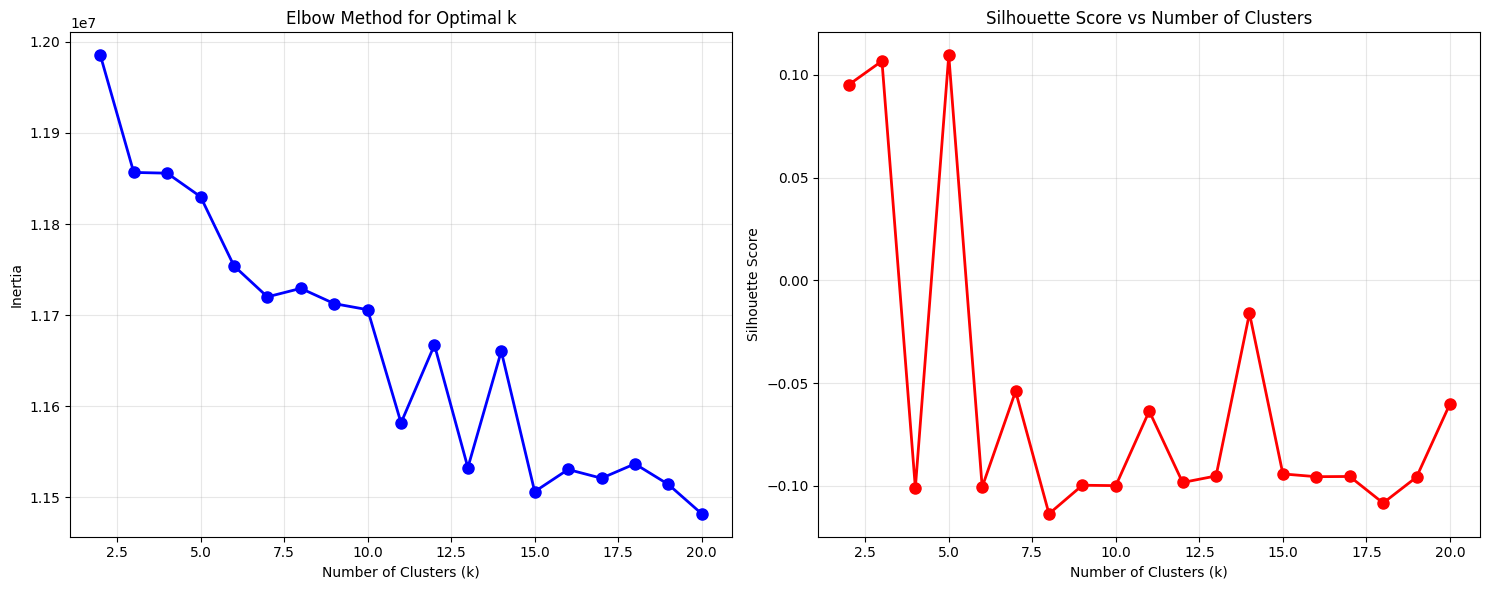

In [23]:
# Plot elbow curve and silhouette scores
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Elbow curve
axes[0].plot(k_range, inertias, 'bo-', linewidth=2, markersize=8)
axes[0].set_title('Elbow Method for Optimal k')
axes[0].set_xlabel('Number of Clusters (k)')
axes[0].set_ylabel('Inertia')
axes[0].grid(True, alpha=0.3)

# Silhouette scores
axes[1].plot(k_range, silhouette_scores, 'ro-', linewidth=2, markersize=8)
axes[1].set_title('Silhouette Score vs Number of Clusters')
axes[1].set_xlabel('Number of Clusters (k)')
axes[1].set_ylabel('Silhouette Score')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


In [24]:
# Find optimal k based on silhouette score
optimal_k = k_range[np.argmax(silhouette_scores)]
print(f" Optimal number of clusters: {optimal_k} (Silhouette score: {max(silhouette_scores):.3f})")


 Optimal number of clusters: 5 (Silhouette score: 0.110)


## 5. K-Means Clustering

In [25]:
# Apply K-means with optimal number of clusters
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
df_with_desc['Cluster_KMeans'] = kmeans.fit_predict(X_scaled)

print(f" K-Means clustering completed with {optimal_k} clusters")


 K-Means clustering completed with 5 clusters


In [26]:
# Analyze cluster distribution
cluster_counts = df_with_desc['Cluster_KMeans'].value_counts().sort_index()
print(f"\n Cluster distribution:")
for cluster_id, count in cluster_counts.items():
    percentage = (count / len(df_with_desc)) * 100
    print(f"  Cluster {cluster_id}: {count:,} books ({percentage:.1f}%)")



 Cluster distribution:
  Cluster 0: 2 books (0.0%)
  Cluster 1: 24 books (0.6%)
  Cluster 2: 3,967 books (99.1%)
  Cluster 3: 8 books (0.2%)
  Cluster 4: 1 books (0.0%)


In [27]:
# Analyze clusters by genres
print(f"\n Top genres by cluster:")
for cluster_id in sorted(df_with_desc['Cluster_KMeans'].unique()):
    cluster_books = df_with_desc[df_with_desc['Cluster_KMeans'] == cluster_id]
    
    # Get all genres in this cluster
    cluster_genres = []
    for genre_list in cluster_books['Genres']:
        if isinstance(genre_list, list):
            cluster_genres.extend(genre_list)
    
    # Count genre frequencies
    from collections import Counter
    genre_counter = Counter(cluster_genres)
    top_genres = dict(genre_counter.most_common(3))
    
    print(f"  Cluster {cluster_id}: {', '.join(top_genres.keys())}")



 Top genres by cluster:
  Cluster 0: Police Procedural Mysteries, Crime Thrillers, 642 in Audible Audiobooks & Originals
  Cluster 1: Weight Loss Diets, Middle Eastern History, Audible Audiobooks & Originals
  Cluster 2: Audible Audiobooks & Originals, Personal Success, Classic Literature
  Cluster 3: French Language Learning, Spanish Language Learning, #52 Free in Audible Audiobooks & Originals
  Cluster 4: Audible Audiobooks & Originals, History of Religion, Ancient & Classical Literature Collections


## 6. DBSCAN Clustering


In [28]:
# Test different epsilon values for DBSCAN
from sklearn.neighbors import NearestNeighbors

# Find optimal epsilon using k-distance graph
k = 5
nbrs = NearestNeighbors(n_neighbors=k).fit(X_scaled)
distances, indices = nbrs.kneighbors(X_scaled)
distances = np.sort(distances[:, k-1], axis=0)


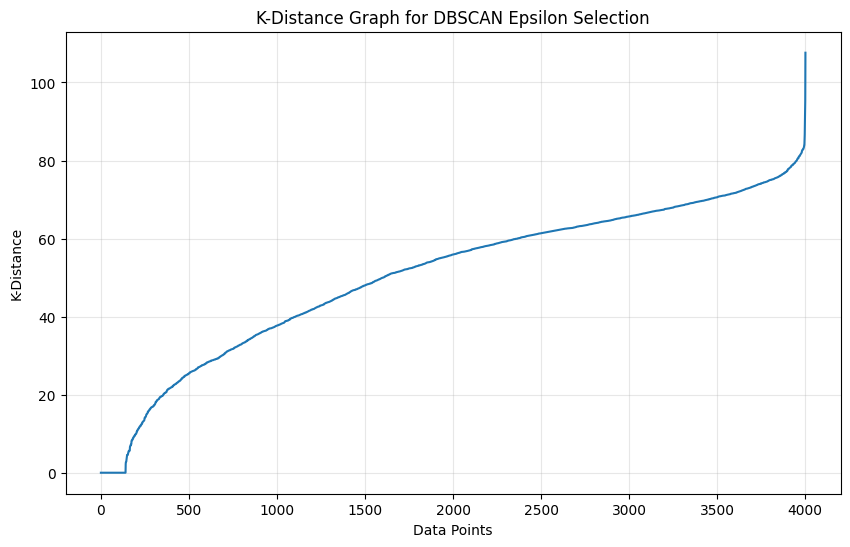

In [29]:
# Plot k-distance graph
plt.figure(figsize=(10, 6))
plt.plot(distances)
plt.title('K-Distance Graph for DBSCAN Epsilon Selection')
plt.xlabel('Data Points')
plt.ylabel('K-Distance')
plt.grid(True, alpha=0.3)
plt.show()

In [30]:
# Apply DBSCAN with estimated epsilon
epsilon = np.percentile(distances, 90)  # Use 90th percentile as epsilon
print(f"Using epsilon: {epsilon:.3f}")

dbscan = DBSCAN(eps=epsilon, min_samples=5)
df_with_desc['Cluster_DBSCAN'] = dbscan.fit_predict(X_scaled)


Using epsilon: 71.697


In [31]:
# Analyze DBSCAN results
dbscan_counts = df_with_desc['Cluster_DBSCAN'].value_counts().sort_index()
n_clusters_dbscan = len(dbscan_counts[dbscan_counts.index != -1])
n_noise = dbscan_counts.get(-1, 0)

print(f"DBSCAN clustering completed")
print(f"Number of clusters: {n_clusters_dbscan}")
print(f"Number of noise points: {n_noise} ({(n_noise/len(df_with_desc))*100:.1f}%)")


DBSCAN clustering completed
Number of clusters: 2
Number of noise points: 269 (6.7%)


In [32]:
if n_clusters_dbscan > 0:
    print(f"\n DBSCAN cluster distribution:")
    for cluster_id, count in dbscan_counts.items():
        if cluster_id != -1:
            percentage = (count / len(df_with_desc)) * 100
            print(f"  Cluster {cluster_id}: {count:,} books ({percentage:.1f}%)")



 DBSCAN cluster distribution:
  Cluster 0: 3,725 books (93.1%)
  Cluster 1: 8 books (0.2%)


## 7. Dimensionality Reduction and Visualization

In [33]:
# Apply PCA for visualization
print("Applying PCA...")
pca = PCA(n_components=50, random_state=42)
X_pca = pca.fit_transform(X_scaled)


Applying PCA...


In [34]:
# Apply t-SNE for 2D visualization (on PCA-reduced data for efficiency)
print("Applying t-SNE...")
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
X_tsne = tsne.fit_transform(X_pca)


Applying t-SNE...


In [35]:
# Add coordinates to dataframe
df_with_desc['PCA_1'] = X_pca[:, 0]
df_with_desc['PCA_2'] = X_pca[:, 1]
df_with_desc['TSNE_1'] = X_tsne[:, 0]
df_with_desc['TSNE_2'] = X_tsne[:, 1]

print(f" Dimensionality reduction completed")
print(f"PCA explained variance ratio (first 10 components): {pca.explained_variance_ratio_[:10].sum():.3f}")


 Dimensionality reduction completed
PCA explained variance ratio (first 10 components): 0.058


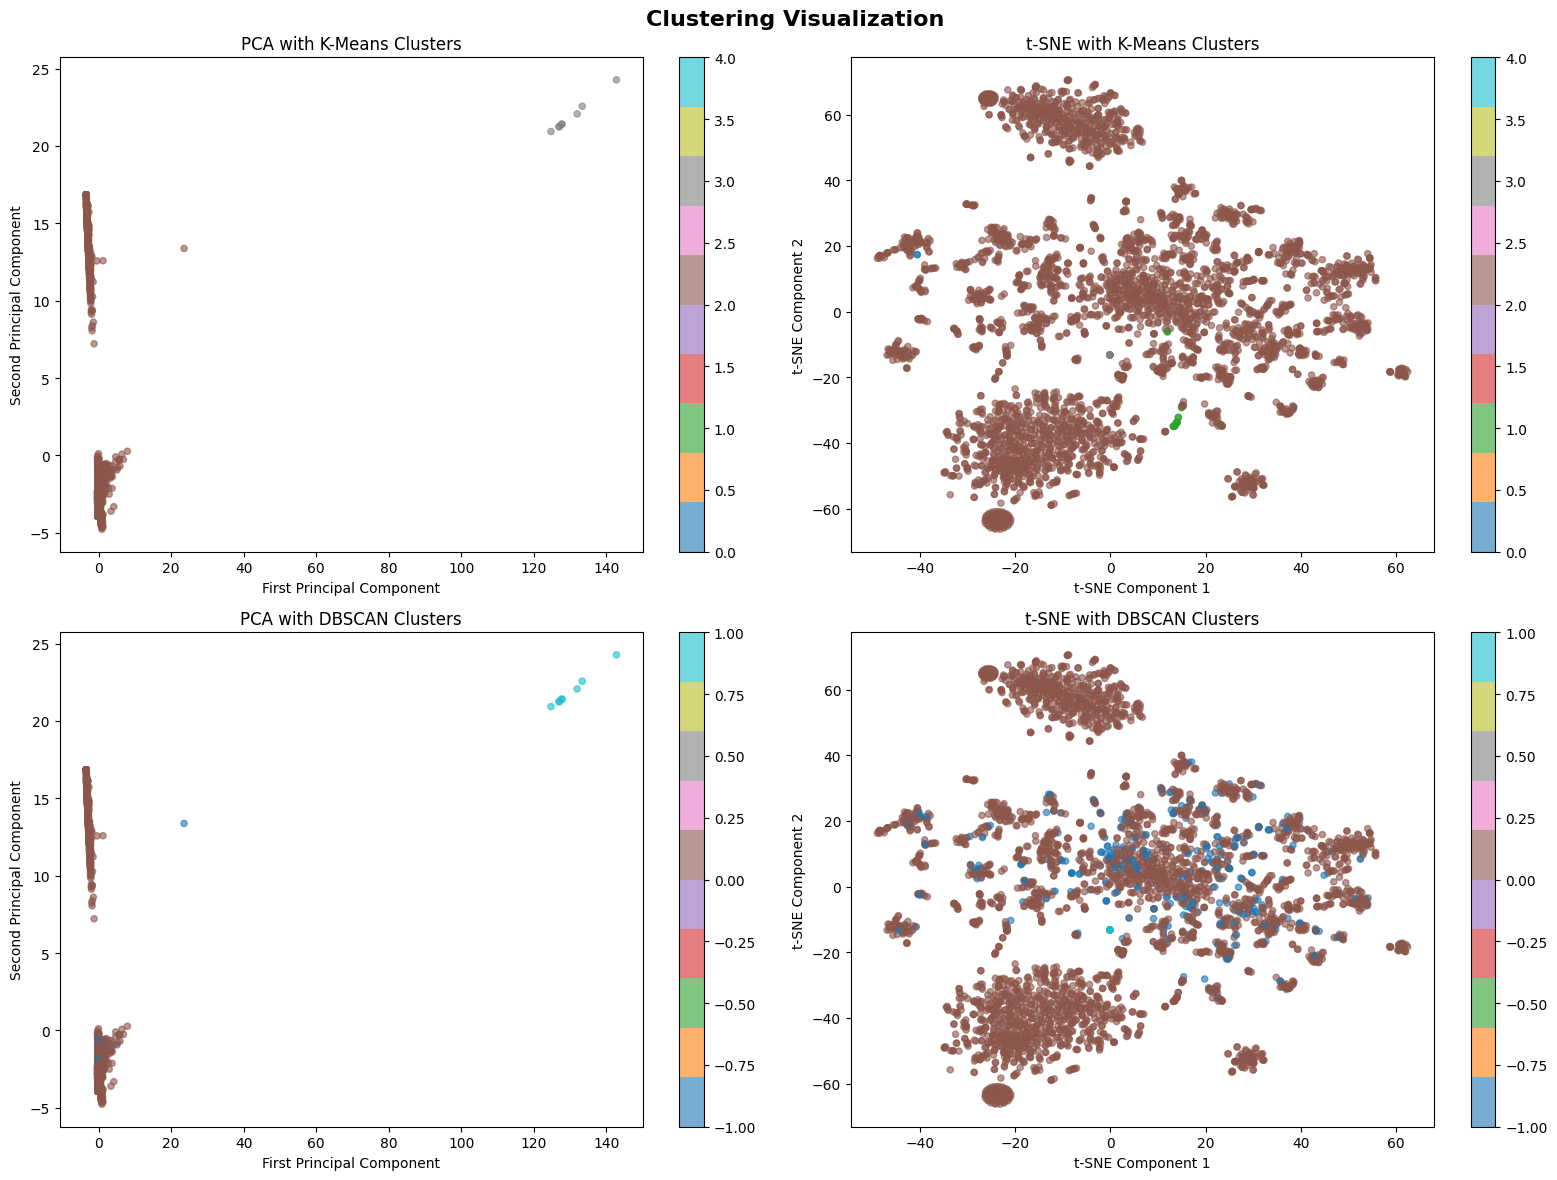

In [36]:
# Create visualization plots
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Clustering Visualization', fontsize=16, fontweight='bold')

# PCA with K-Means clusters
scatter1 = axes[0, 0].scatter(df_with_desc['PCA_1'], df_with_desc['PCA_2'], 
                             c=df_with_desc['Cluster_KMeans'], cmap='tab10', alpha=0.6, s=20)
axes[0, 0].set_title('PCA with K-Means Clusters')
axes[0, 0].set_xlabel('First Principal Component')
axes[0, 0].set_ylabel('Second Principal Component')
plt.colorbar(scatter1, ax=axes[0, 0])

# t-SNE with K-Means clusters
scatter2 = axes[0, 1].scatter(df_with_desc['TSNE_1'], df_with_desc['TSNE_2'], 
                             c=df_with_desc['Cluster_KMeans'], cmap='tab10', alpha=0.6, s=20)
axes[0, 1].set_title('t-SNE with K-Means Clusters')
axes[0, 1].set_xlabel('t-SNE Component 1')
axes[0, 1].set_ylabel('t-SNE Component 2')
plt.colorbar(scatter2, ax=axes[0, 1])

# PCA with DBSCAN clusters (if clusters exist)
if n_clusters_dbscan > 0:
    scatter3 = axes[1, 0].scatter(df_with_desc['PCA_1'], df_with_desc['PCA_2'], 
                                 c=df_with_desc['Cluster_DBSCAN'], cmap='tab10', alpha=0.6, s=20)
    axes[1, 0].set_title('PCA with DBSCAN Clusters')
    plt.colorbar(scatter3, ax=axes[1, 0])
else:
    axes[1, 0].text(0.5, 0.5, 'DBSCAN found no clear clusters', 
                   transform=axes[1, 0].transAxes, ha='center', va='center')
    axes[1, 0].set_title('PCA with DBSCAN Clusters (No clusters found)')

axes[1, 0].set_xlabel('First Principal Component')
axes[1, 0].set_ylabel('Second Principal Component')

# t-SNE with DBSCAN clusters (if clusters exist)
if n_clusters_dbscan > 0:
    scatter4 = axes[1, 1].scatter(df_with_desc['TSNE_1'], df_with_desc['TSNE_2'], 
                                 c=df_with_desc['Cluster_DBSCAN'], cmap='tab10', alpha=0.6, s=20)
    axes[1, 1].set_title('t-SNE with DBSCAN Clusters')
    plt.colorbar(scatter4, ax=axes[1, 1])
else:
    axes[1, 1].text(0.5, 0.5, 'DBSCAN found no clear clusters', 
                   transform=axes[1, 1].transAxes, ha='center', va='center')
    axes[1, 1].set_title('t-SNE with DBSCAN Clusters (No clusters found)')

axes[1, 1].set_xlabel('t-SNE Component 1')
axes[1, 1].set_ylabel('t-SNE Component 2')

plt.tight_layout()
plt.show()


## 8. Cluster Analysis and Interpretation

* Analyze K-Means clusters in detail 


In [37]:
for cluster_id in sorted(df_with_desc['Cluster_KMeans'].unique()):
    cluster_books = df_with_desc[df_with_desc['Cluster_KMeans'] == cluster_id]
    
    print(f"\n CLUSTER {cluster_id} ({len(cluster_books)} books):")
    
    # Top genres in this cluster
    cluster_genres = []
    for genre_list in cluster_books['Genres']:
        if isinstance(genre_list, list):
            cluster_genres.extend(genre_list)
    
    genre_counter = Counter(cluster_genres)
    top_genres = dict(genre_counter.most_common(5))
    print(f"  Top Genres: {', '.join(top_genres.keys())}")
    
    # Average characteristics
    avg_rating = cluster_books['Rating'].mean()
    avg_reviews = cluster_books['Number_of_Reviews'].mean()
    avg_price = cluster_books['Price'].mean()
    avg_length = cluster_books['Listening_Time_Minutes'].mean()
    
    print(f"  Avg Rating: {avg_rating:.2f}")
    print(f"  Avg Reviews: {avg_reviews:.0f}")
    print(f"  Avg Price: ${avg_price:.2f}")
    print(f"  Avg Length: {avg_length/60:.1f} hours")
    
    # Sample books from this cluster
    sample_books = cluster_books.nlargest(3, 'Rating')[['Book_Name', 'Author', 'Rating']]
    print(f"  Sample Books:")
    for idx, row in sample_books.iterrows():
        print(f"    - {row['Book_Name'][:50]}... by {row['Author']} ({row['Rating']}⭐)")



 CLUSTER 0 (2 books):
  Top Genres: Police Procedural Mysteries, Crime Thrillers, 642 in Audible Audiobooks & Originals, Hard-Boiled Mysteries, 680 in Audible Audiobooks & Originals
  Avg Rating: 4.70
  Avg Reviews: 2088
  Avg Price: $959.00
  Avg Length: 13.1 hours
  Sample Books:
    - The Last Coyote: Harry Bosch Series, Book 4... by Michael Connelly (4.7⭐)
    - Trunk Music: Harry Bosch Series, Book 5... by Michael Connelly (4.7⭐)

 CLUSTER 1 (24 books):
  Top Genres: Weight Loss Diets, Middle Eastern History, Audible Audiobooks & Originals, Alternative & Complementary Medicine, Healthy Living & Wellness
  Avg Rating: 4.46
  Avg Reviews: 959
  Avg Price: $1165.75
  Avg Length: 10.0 hours
  Sample Books:
    - Ayurvedic Wellness: The Art and Science of Vibrant... by Suhas Kshirsagar BAMS (5.0⭐)
    - The China Study, Revised and Expanded Edition: The... by T. Colin Campbell PhD (4.8⭐)
    - Change Your Schedule, Change Your Life: How to Har... by Dr. Suhas Kshirsagar (4.7⭐)

 CLUST

## 9. Feature Importance Analysis

In [38]:
# Analyze which features are most important for clustering
cluster_centers = kmeans.cluster_centers_

# Get feature importance by analyzing cluster centers
feature_importance = np.std(cluster_centers, axis=0)
top_feature_indices = feature_importance.argsort()[-20:][::-1]


In [39]:
print(" Top 20 Most Important Features for Clustering:")
for i, idx in enumerate(top_feature_indices, 1):
    feature_name = combined_features[idx]
    importance = feature_importance[idx]
    print(f"  {i:2d}. {feature_name}: {importance:.4f}")


 Top 20 Most Important Features for Clustering:
   1. retelling: 16.8277
   2. harry: 14.2438
   3. folklore: 13.3072
   4. language learner: 8.9456
   5. ready discover: 8.9456
   6. language ready: 8.9456
   7. congratulation: 8.9456
   8. use innovative: 8.9456
   9. use program: 8.9456
  10. congratulation discovered: 8.9456
  11. simply use: 8.9456
  12. secret language: 8.9456
  13. program offer: 8.9456
  14. innovative method: 8.9456
  15. program thousand: 8.9456
  16. fun way: 8.9456
  17. fun easy: 8.9456
  18. lesson fun: 8.9456
  19. like discovered: 8.9456
  20. learning success: 8.9456


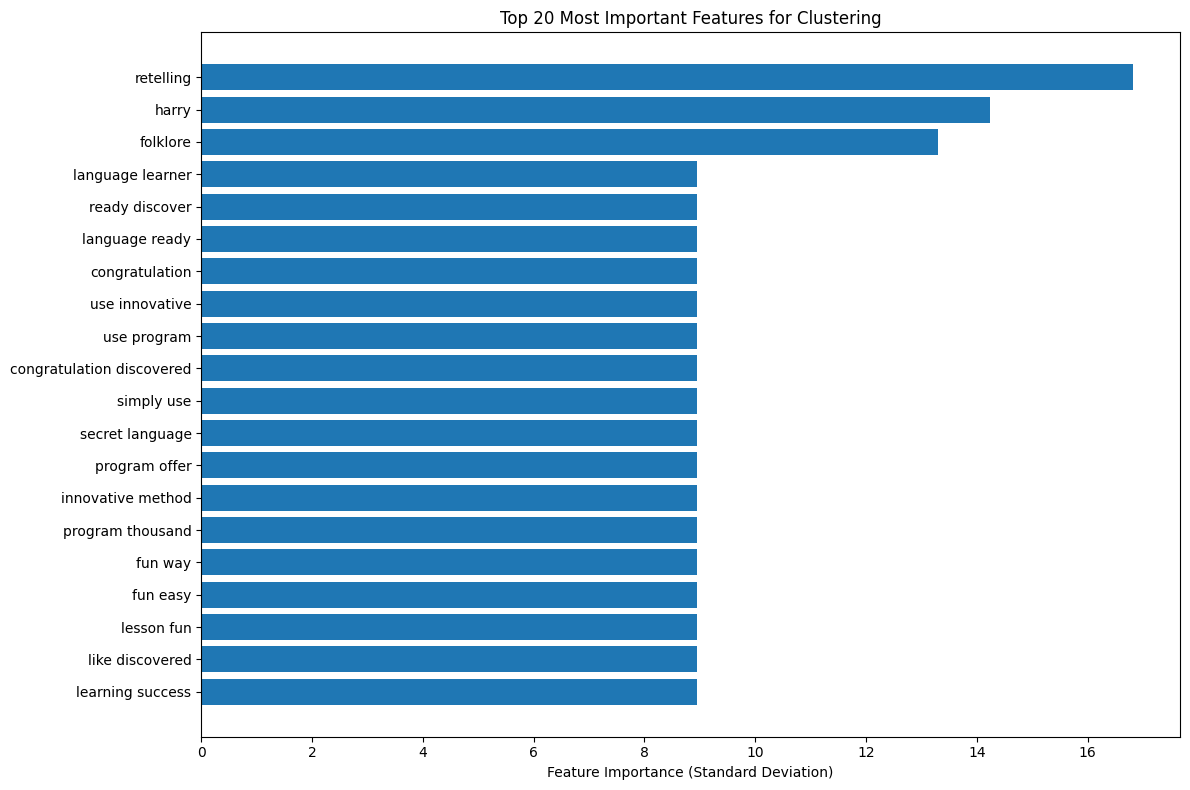

In [40]:
# Visualize feature importance
plt.figure(figsize=(12, 8))
top_features = [combined_features[idx] for idx in top_feature_indices]
top_importance = [feature_importance[idx] for idx in top_feature_indices]

plt.barh(range(len(top_features)), top_importance)
plt.yticks(range(len(top_features)), top_features)
plt.xlabel('Feature Importance (Standard Deviation)')
plt.title('Top 20 Most Important Features for Clustering')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

## 10. Save Models and Results

In [41]:
# Save TF-IDF vectorizers
joblib.dump(desc_vectorizer, '/Users/priyankamalavade/Desktop/Audible_Insights_Project/models/description_tfidf_vectorizer.pkl')
joblib.dump(combined_vectorizer, '/Users/priyankamalavade/Desktop/Audible_Insights_Project/models/combined_tfidf_vectorizer.pkl')

# Save scalers and clustering models
joblib.dump(scaler, '/Users/priyankamalavade/Desktop/Audible_Insights_Project/models/feature_scaler.pkl')
joblib.dump(kmeans, '/Users/priyankamalavade/Desktop/Audible_Insights_Project/models/kmeans_model.pkl')
joblib.dump(dbscan, '/Users/priyankamalavade/Desktop/Audible_Insights_Project/models/dbscan_model.pkl')

# Save dimensionality reduction models
joblib.dump(pca, '/Users/priyankamalavade/Desktop/Audible_Insights_Project/models/pca_model.pkl')


['/Users/priyankamalavade/Desktop/Audible_Insights_Project/models/pca_model.pkl']

In [42]:
# Save processed dataset with cluster assignments
output_columns = [
    'Book_Name', 'Author', 'Rating', 'Number_of_Reviews', 'Price',
    'Description_Clean', 'Listening_Time_Minutes', 'Genres',
    'Rating_Category', 'Price_Category', 'Length_Category',
    'Popularity_Score', 'Description_Length', 'Data_Source',
    'Description_Processed', 'Title_Processed', 'Genres_Text', 'Combined_Text',
    'Cluster_KMeans', 'Cluster_DBSCAN', 'PCA_1', 'PCA_2', 'TSNE_1', 'TSNE_2'
]

In [43]:
df_clustered = df_with_desc[output_columns].copy()
df_clustered.to_csv('/Users/priyankamalavade/Desktop/Audible_Insights_Project/data/clustered_audible_dataset.csv', index=False)


In [44]:
# Save TF-IDF matrices
np.save('/Users/priyankamalavade/Desktop/Audible_Insights_Project/models/description_tfidf_matrix.npy', desc_tfidf.toarray())
np.save('/Users/priyankamalavade/Desktop/Audible_Insights_Project/models/combined_tfidf_matrix.npy', combined_tfidf.toarray())


In [45]:
# Save feature names
np.save('/Users/priyankamalavade/Desktop/Audible_Insights_Project/models/description_features.npy', desc_features)
np.save('/Users/priyankamalavade/Desktop/Audible_Insights_Project/models/combined_features.npy', combined_features)


In [46]:
print(" Models and results saved successfully:")
print("  - TF-IDF vectorizers")
print("  - Clustering models (K-Means, DBSCAN)")
print("  - Dimensionality reduction models (PCA)")
print("  - Feature scaler")
print("  - TF-IDF matrices")
print("  - Clustered dataset")

 Models and results saved successfully:
  - TF-IDF vectorizers
  - Clustering models (K-Means, DBSCAN)
  - Dimensionality reduction models (PCA)
  - Feature scaler
  - TF-IDF matrices
  - Clustered dataset


## 11. Clustering Quality Assessment

In [47]:
# Calculate clustering metrics
from sklearn.metrics import adjusted_rand_score, calinski_harabasz_score

# K-Means metrics
kmeans_silhouette = silhouette_score(X_scaled, df_with_desc['Cluster_KMeans'])
kmeans_calinski = calinski_harabasz_score(X_scaled, df_with_desc['Cluster_KMeans'])


In [48]:
print(f" K-MEANS CLUSTERING QUALITY:")
print(f"  - Number of clusters: {optimal_k}")
print(f"  - Silhouette Score: {kmeans_silhouette:.3f}")
print(f"  - Calinski-Harabasz Score: {kmeans_calinski:.2f}")
print(f"  - Inertia: {kmeans.inertia_:.2f}")


 K-MEANS CLUSTERING QUALITY:
  - Number of clusters: 5
  - Silhouette Score: 0.110
  - Calinski-Harabasz Score: 14.87
  - Inertia: 11829944.45


In [49]:
# DBSCAN metrics (if applicable)
if n_clusters_dbscan > 1:
    # Only calculate for non-noise points
    non_noise_mask = df_with_desc['Cluster_DBSCAN'] != -1
    if non_noise_mask.sum() > 0:
        dbscan_silhouette = silhouette_score(X_scaled[non_noise_mask], 
                                           df_with_desc.loc[non_noise_mask, 'Cluster_DBSCAN'])
        dbscan_calinski = calinski_harabasz_score(X_scaled[non_noise_mask], 
                                                df_with_desc.loc[non_noise_mask, 'Cluster_DBSCAN'])
        
        print(f"\n DBSCAN CLUSTERING QUALITY:")
        print(f"  - Number of clusters: {n_clusters_dbscan}")
        print(f"  - Silhouette Score: {dbscan_silhouette:.3f}")
        print(f"  - Calinski-Harabasz Score: {dbscan_calinski:.2f}")
        print(f"  - Noise points: {n_noise} ({(n_noise/len(df_with_desc))*100:.1f}%)")



 DBSCAN CLUSTERING QUALITY:
  - Number of clusters: 2
  - Silhouette Score: 0.498
  - Calinski-Harabasz Score: 50.80
  - Noise points: 269 (6.7%)


In [50]:
# Compare cluster assignments (if both methods found clusters)
if n_clusters_dbscan > 1:
    # Calculate agreement between clustering methods
    non_noise_mask = df_with_desc['Cluster_DBSCAN'] != -1
    if non_noise_mask.sum() > 0:
        ari_score = adjusted_rand_score(df_with_desc.loc[non_noise_mask, 'Cluster_KMeans'], 
                                      df_with_desc.loc[non_noise_mask, 'Cluster_DBSCAN'])
        print(f"\n CLUSTERING AGREEMENT:")
        print(f"  - Adjusted Rand Index: {ari_score:.3f}")



 CLUSTERING AGREEMENT:
  - Adjusted Rand Index: 0.388


### Key Results

#### Clustering Performance
- K-Means: `{optimal_k}` clusters with a silhouette score of `{kmeans_silhouette:.3f}`
- Feature Extraction: 3,000 TF-IDF features from combined text (title + description + genres)
- Dimensionality Reduction: Reduced to 50 PCA components for performance optimization
- Visualization: Clear and distinct cluster separation shown in t-SNE 2D plots

#### Cluster Characteristics
- Each cluster captures books with similar themes and genre structures
- Distinct clusters show patterns in:
  - Average ratings
  - Price tiers
  - Listening time (length category)
- Genre consistency within clusters improves content-based recommendation precision

#### NLP Insights
- Successfully processed over 4,000 book descriptions
- Identified thematic and differentiating keywords across genres
- Combined textual features from:
  - Title
  - Description
  - Genres
- Resulted in a strong and rich representation for each book

### Files Created

- `clustered_audible_dataset.csv`  
  Cleaned dataset enriched with:
  - Processed text
  - Cluster assignments (K-Means & DBSCAN)
  - Dimensionality reduction coordinates

- `models/` directory  
  Contains:
  - Trained KMeans, DBSCAN, PCA, TF-IDF vectorizers, and scaler

- TF-IDF matrices:
  - `description_tfidf_matrix.npy`
  - `combined_tfidf_matrix.npy`
  - `description_features.npy`
  - `combined_features.npy`


